# Comparison of effect sizes

In [1]:
suppressPackageStartupMessages({
  library(dplyr)
  library(RColorBrewer)
  library(data.table)
  library(ggplot2)
  library(viridis)
  library(grid)
  library(gridExtra)
  library(patchwork)
  library(ggsci)
  library(ggpubr)
  library(ggrastr)
  library(DESeq2)
})

### Load data

In [2]:
sim_dir <- "/home/lmoral7/lmprojects/altsplicing-methods/simulations/output"
fig_dir <- "/home/lmoral7/lmprojects/altsplicing-methods/simulations/results/figures_v3/effects"
runs <- list.dirs(sim_dir,recursive = FALSE,full.names = FALSE) 
runs<-runs[grepl("run",runs)]

In [3]:
psi_effects<-readRDS(file = "../data/ground_truth_effect_sizes_on_lenCorrected_logitPSI.RData")

In [4]:
# Load DESeq objects 
all_dds <- lapply(runs,function(run,...){
                load(file = file.path(sim_dir,run,"trex_v2/SE.dds.cell_line.batch.RData")) 
                return(dds) 
           })
names(all_dds)<-sub("run_","",runs)

### Ground truth effects

In [5]:
gt_effects <- lapply(names(psi_effects),function(run,...){
                    gt<-as.data.frame(psi_effects[[run]]) %>%
                        mutate(bes=sub("_.*","",run),
                               run=sub(".*_","",run))
                    gt$event_id<-rownames(gt)
                    return(gt)
              }) %>%
              do.call(rbind,.) %>%
              arrange(event_id)

In [6]:
gt_cond_effect <- gt_effects %>%
                    dplyr::select(event_id,cell_lineSRSF9.KD,bes,run)%>%
                    dplyr::group_by(event_id)%>%
                    dplyr::summarise(cell_lineSRSF9.KD_mean= mean(cell_lineSRSF9.KD),
                                     cell_lineSRSF9.KD_sd = sd(cell_lineSRSF9.KD)) 

In [7]:
gt_batch_effect <- gt_effects %>%
                    dplyr::select(event_id,batch,bes,run)%>%
                    dplyr::group_by(event_id,bes)%>%
                    dplyr::summarise(batch_mean = mean(batch),
                                     batch_sd = sd(batch)) 

`summarise()` has grouped output by 'event_id'. You can override using the
`.groups` argument.


### Predicted effects

In [8]:
pred_cond_effect<-lapply(names(all_dds),function(run,...){
    dds<-all_dds[[run]]
    res<-results(dds,name = "trex_countA.cell_lineSRSF9.KD") %>%
         as.data.frame()%>%
         mutate(bes=sub("_.*","",run),
                run=sub(".*_","",run))
    res$event_id<-rownames(res)
    return(res)
})
names(pred_cond_effect)<-names(all_dds)

pred_cond_effect<-pred_cond_effect %>%
                    do.call(rbind,.) %>%
                    dplyr::group_by(event_id) %>%
                    dplyr::summarise(across(baseMean:padj,mean,.names = '{col}_mean'),
                                     across(baseMean:padj,sd,.names = '{col}_sd')) 

In [9]:
pred_batch_effect<-lapply(names(all_dds),function(run,...){
    dds<-all_dds[[run]]
    res<-results(dds,name = "trex_countA.batch") %>%
         as.data.frame()%>%
         mutate(bes=sub("_.*","",run),
                run=sub(".*_","",run))
    res$event_id<-rownames(res)
    return(res)
})
names(pred_batch_effect)<-names(all_dds)

pred_batch_effect<-pred_batch_effect %>%
                    do.call(rbind,.) %>%
                    dplyr::group_by(bes,event_id) %>%
                    dplyr::summarise(across(baseMean:padj,mean,.names = '{col}_mean'),
                                     across(baseMean:padj,sd,.names = '{col}_sd')) 

`summarise()` has grouped output by 'bes'. You can override using the `.groups`
argument.


## Condition effect

In [10]:
cond_ref <- inner_join(pred_cond_effect,gt_cond_effect) %>%
            filter(abs(cell_lineSRSF9.KD_mean)>1e-6) # ground truth that couldn't be calculated because of zero counts

Joining, by = "event_id"


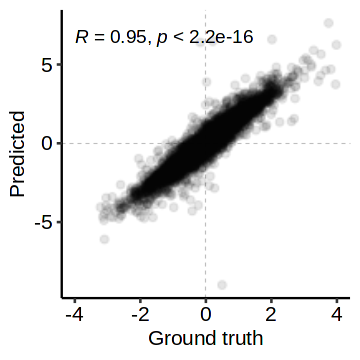

In [11]:
options(repr.plot.width=3,repr.plot.height=3)
p<-ggplot(cond_ref ,aes(x=cell_lineSRSF9.KD_mean,y=log2FoldChange_mean))+
    geom_vline(xintercept = 0,linewidth=0.25,color="grey",linetype="dashed")+
    geom_hline(yintercept = 0,linewidth=0.25,color="grey",linetype="dashed")+
    rasterise(geom_point(alpha=0.1))+
    labs(x="Ground truth",y="Predicted")+
    stat_cor(method="pearson",label.x.npc = "left",label.y.npc = "top")+
    theme_pubr()+
    scale_x_continuous(limits = c(-4,4),breaks = c(-4,-2,0,2,4))
ggsave(p,file=file.path(fig_dir,"condition_effects.pdf"),device="pdf",width = 3,height = 3)
p

## Batch effect

In [12]:
batch_ref<-inner_join(pred_batch_effect,gt_batch_effect)%>%
            mutate(bes = paste("bes=",bes)) %>%
            filter(abs(batch_mean)>1e-6) # ground truth that couldn't be calculated because of zero counts

Joining, by = c("bes", "event_id")


In [13]:
options(repr.plot.width=4,repr.plot.height=4)
for(b in unique(batch_ref$bes)){
    p<-batch_ref %>%
        filter(bes==b) %>%
        ggplot(.,aes(x=batch_mean,y=log2FoldChange_mean))+
        geom_vline(xintercept = 0,linewidth=0.25,color="grey",linetype="dashed")+
        geom_hline(yintercept = 0,linewidth=0.25,color="grey",linetype="dashed")+
            rasterise(geom_point(alpha=0.1,size=1))+
            labs(x="Ground truth",y=paste0("Predicted (",b,")"))+
            stat_cor(method="pearson",label.x.npc = "left",label.y.npc = "top")+
            theme_pubr()+
            theme(text = element_text(size=16),
                  strip.background = element_rect(fill = "white",color = "white",size = 1),
                  strip.text = element_text(size=14,face="italic"))
    ggsave(p,file=file.path(fig_dir,paste0("batch_effects_bes",sub("bes =  ","",b),".pdf")),device="pdf",width = 3,height = 3)
}

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


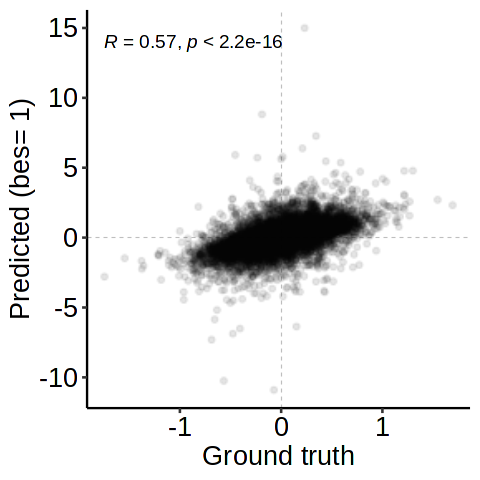

In [14]:
p

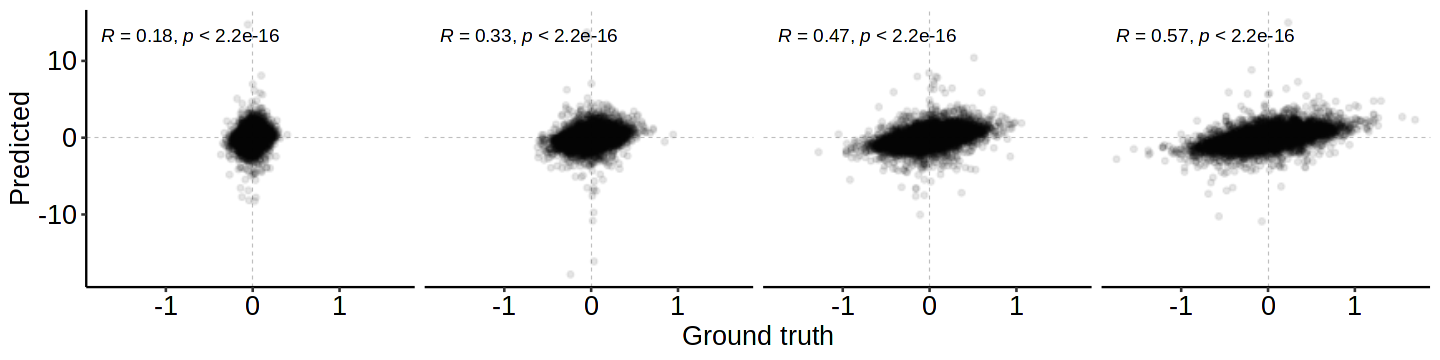

In [15]:
options(repr.plot.width=12,repr.plot.height=3)
p<-batch_ref %>%
    ggplot(.,aes(x=batch_mean,y=log2FoldChange_mean))+
    geom_vline(xintercept = 0,linewidth=0.25,color="grey",linetype="dashed")+
    geom_hline(yintercept = 0,linewidth=0.25,color="grey",linetype="dashed")+
        rasterise(geom_point(alpha=0.1,size=1))+
        labs(x="Ground truth",y="Predicted")+
        facet_wrap(~bes,ncol = 4)+
        stat_cor(method="pearson",label.x.npc = "left",label.y.npc = "top")+
        theme_pubr()+
        theme(text = element_text(size=16),
             strip.background = element_rect(fill = "white",color = "white",size = 1),
             strip.text = element_blank())
ggsave(p,file=file.path(fig_dir,"batch_effects_grid.pdf"),device="pdf",width = 12,height = 3)
p